### Aggiunta pacchetti

In [ ]:
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

## Machine Learning su Spark
Con le API di basso livello di Spark occorrerebbe definire un oggetto SparkContext configurato con un oggetto SparkConf.  
Mentre con le nuove API si utilizza la classe SparkSession con il metodo builder per creare l'oggetto Spark con tutte le funzionalità necessarie.


In [1]:
import time
import os.path
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay

from pyspark.sql import SparkSession
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# OLD WAY
# from pyspark import SparkContext, SparkConf
# conf = SparkConf().setAppName("app_name").setMaster("master")
# sc = SparkContext.getOrCreate(conf=conf)

spark = SparkSession.builder.appName("app_name").getOrCreate()

Scarichiamo il dataset [connect-4](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html#connect-4) dai dataset LIBSVM di [Chih-Jen Lin](https://www.csie.ntu.edu.tw/~cjlin/index.html)  
Un dataset per classificazione multipla (3 classi) con __67.557 esempi__.
Ogni esempio ha 126 caratteristiche.



In [2]:
url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/connect-4"

if not os.path.isfile("work/data/connect-4.txt"):
    urlretrieve(url, "work/data/connect-4.txt")

Carichiamo il dataset con il formato libsvm grazie al metodo di spark.  
Viene indicato il numero di feature per velocizzare la scansione.

In [3]:
data = spark.read.format("libsvm").load("work/data/connect-4.txt",numFeatures=126)

# Dividiamo il dataset in train e test set
(train_set, test_set) = data.randomSplit([0.7, 0.3])

Definiamo le _trasformazioni_ da effettuare

In [4]:
# Definiamo l'indicizziamo delle etichette, aggiungendo i metadati alla colonna dell'etichetta
label_indexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)
# Definiziamo l'indicizziamo delle features, aggiungendo i metadati alla colonna delle features
feature_indexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(data)

# Definiamo il classificatore indicando le etichette indicizzate prima
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Definiamo l'operazione di convertire l'indice della label in stringa
label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=label_indexer.labels)

# Definiamo la pipeline di trasformazioni
pipeline = Pipeline(stages=[label_indexer, feature_indexer, rf, label_converter])

Definiamo i parametri, facciamo i vari addestramenti e ci salviamo i risultati

In [23]:
params = { "num_trees":[5,10,20], "max_depth":[10,15,20,30] }

results = []
for num_trees in params["num_trees"]:
    for max_depth in params["max_depth"]:
        start = time.time()

        # Configurazione iperparametri
        rf.setNumTrees(num_trees)
        rf.setMaxDepth(max_depth)

        # Addestramento del modello 
        model = pipeline.fit(train_set)
        # Esecuzione del modello sul test set
        predictions = model.transform(test_set)
        # Calcolo dell'accuratezza
        evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
        accuracy = evaluator.evaluate(predictions)

        end = time.time()

        print(f"Accuracy: {accuracy} (num_trees={num_trees}, max_depth={max_depth}, time={end-start})")
        # Salviamo i risultati
        results.append((num_trees, max_depth, accuracy, end-start))

Accuracy: 0.7214982906406382 (num_trees=5, max_depth=10, time=1.896934986114502)
Accuracy: 0.7624238220284397 (num_trees=5, max_depth=15, time=2.3099443912506104)
Accuracy: 0.7775850963682307 (num_trees=5, max_depth=20, time=4.17233943939209)
Accuracy: 0.7795669622950008 (num_trees=5, max_depth=30, time=7.5702643394470215)
Accuracy: 0.7221919437150077 (num_trees=10, max_depth=10, time=1.7091338634490967)
Accuracy: 0.7706981122727048 (num_trees=10, max_depth=15, time=3.55936598777771)
Accuracy: 0.7940345835604221 (num_trees=10, max_depth=20, time=6.999703407287598)
Accuracy: 0.8005251944705941 (num_trees=10, max_depth=30, time=14.140488862991333)
Accuracy: 0.726601595402071 (num_trees=20, max_depth=10, time=2.7235963344573975)
Accuracy: 0.7771391765347074 (num_trees=20, max_depth=15, time=6.298670530319214)
Accuracy: 0.8041916464351186 (num_trees=20, max_depth=20, time=12.700759172439575)
Accuracy: 0.8091958579002131 (num_trees=20, max_depth=30, time=27.923938512802124)


Questi sono i risultati ottenuti dai vari addestramenti.  

Si può notare che utilizzando gli alberi con una profondità superiore a 20, si può ottenere una buona performance. 
Mentre il numero di alberi aumenta un po' l'accuratezza ma soprattutto il tempo di addestramento.  


Text(0.5, 1.0, 'Time vs num_trees')

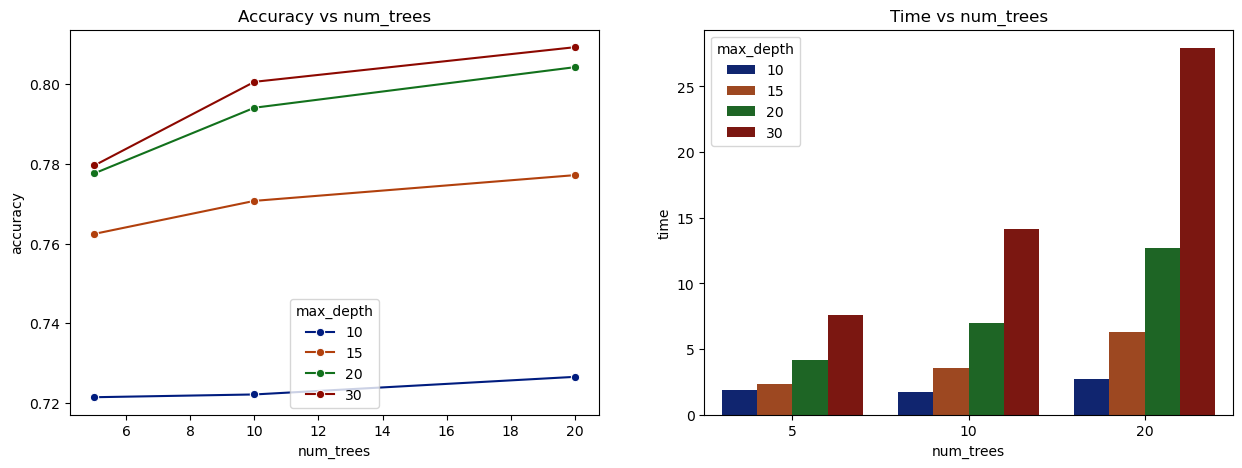

In [30]:
results_df = pd.DataFrame(results, columns=["num_trees", "max_depth", "accuracy", "time"])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(data=results_df, x="num_trees", y="accuracy", hue="max_depth", marker="o", palette="dark", ax=ax[0])
ax[0].set_title("Accuracy vs num_trees")


sns.barplot(data=results_df, x="num_trees", y="time", hue="max_depth", palette="dark", ax=ax[1])
ax[1].set_title("Time vs num_trees")

Approfondiamo il modello con la miglior performance

In [31]:
best_model = pipeline.fit(train_set)

In [32]:
# Faccio le predizioni
predictions = best_model.transform(test_set)

In [33]:
# Selezione esempi di qualche riga da visualizzare
predictions.select("predictedLabel", "label", "features").show(5)

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|          -1.0| -1.0|(126,[0,3,6,11,13...|
|          -1.0| -1.0|(126,[0,3,6,11,13...|
|          -1.0| -1.0|(126,[0,3,6,11,13...|
|           1.0| -1.0|(126,[0,3,7,10,13...|
|          -1.0| -1.0|(126,[0,3,7,10,13...|
+--------------+-----+--------------------+
only showing top 5 rows



In [34]:
# Definisco il valutatore e calcolo l'accuratezza
evaluator = MulticlassClassificationEvaluator( labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuratezza {accuracy}")

rfModel = best_model.stages[2]
print(rfModel) 

Accuratezza 0.8091958579002131
RandomForestClassificationModel: uid=RandomForestClassifier_a246ea5ac46b, numTrees=20, numClasses=3, numFeatures=126


Osservando la matrice di confusione notiamo che il dataset è abbastanza sbilanciato e giustamente il modello è diventato più bravo a predire l'etichetta 2 rispetto alle altre.

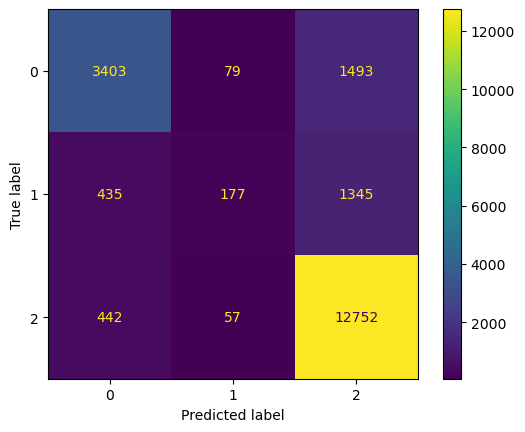

In [37]:
# Matrice di confusione
confusion_matrix = predictions.groupBy("label", "predictedLabel").count()
ConfusionMatrixDisplay(confusion_matrix.toPandas().pivot(index="label", columns="predictedLabel", values="count").fillna(0).values).plot()